In [21]:
%load_ext autoreload
%autoreload 2
import data_pipeline as dp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Machine Learning Model
import catboost as cb

# Data Processing Tools
import pandas as pd

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from enum import Enum
 
# TODO: ADD NICE MODEL SELECTIONS
# TODO: ADD FILTERING TOOLS
# TODO: ADD FREQUENCY GENERATION

class learner:
    def __init__(self, file_paths: list[list[str]], features: list[str] = [], learning_algorithm: str = cb.CatBoostRegressor) -> None:
        self.file_paths = file_paths
        self.features = features
        self.learning_algorithm = learning_algorithm
        self.buildings = ["A", "B", "C"]

    def create_training_data(self):
        list_y = []
        list_X = []
        list_X_pred = []
    
        for i, path in enumerate(self.file_paths):
            print(i)
            y = pd.read_parquet(path[0])
            X_estimated = pd.read_parquet(path[1])
            X_observed = pd.read_parquet(path[2])
            X_pred = pd.read_parquet(path[3])

            # =================  TEST DATA  ================
            X_pred = dp.pred_data_processing(X_pred, self.features)
            X_pred['building'] = i
            print("These are XPREDs features", X_pred.columns.values)
            list_X_pred.append(X_pred)

            # =================TRAINING DATA================
            # Pre-process data
            y = y.dropna()
            X_estimated = X_estimated.drop("date_calc", axis = 1)
            X = pd.concat([X_observed, X_estimated], axis = 0, ignore_index=True)
            
            # BETTER NAME
            X, y= dp.train_data_processing(X, y, self.features)
            
            # ADD A FUNCTION TO GENERATE BUILDING FEATURE.
            X['building'] = i

            # Adding the datasets to the lists
            list_y.append(y)
            list_X.append(X)
        
        # Add all the lists together. However there is a need to add set
        y = pd.concat(list_y, axis= 0)

        X = pd.concat(list_X, axis= 0)
        X_pred = pd.concat(list_X_pred, axis = 0)

        X_train, X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
        
        # Should probably save their date indexes just in case :/

        # Should try scaling later ... :/
        self.X_train, self.X_test, self.X_pred = X_train, X_test, X_pred
        print("These are self XPREDs features", self.X_pred.columns.values)
        return None

    def _scale_sets(self, X_train: pd.DataFrame, X_test: pd.DataFrame, X_pred: pd.DataFrame):
        
        scaler = MinMaxScaler()

        unscaled_X_train = X_train.drop('building', axis = 1)
        X_train_scaled_values = scaler.fit_transform(unscaled_X_train.values)

        X_train_scaled['building'] = X_train['building']

        unscaled_X_test = X_test.drop('building', axis = 1)
        X_test_scaled = scaler.transform(unscaled_X_test)
        X_test_scaled['building'] = X_test['building']
        
        unscaled_X_pred = X_pred.drop('building', axis = 1)
        X_pred_scaled = scaler.transform(unscaled_X_pred)
        X_pred_scaled['building'] = X_pred['building']
        
        return X_train, X_test, X_pred


    def fit_model(self) -> None:
        """
        Based on the selected model the class switches between what model is doing the learning. 
        """

        #============ SHOULD BE PLACED WITHIN A LIST OF FUNCTIONS ===================#
        # Add a function that picks between different models, and processes the data based on this
        train_dataset = cb.Pool(self.X_train, self.y_train)

        self.model = cb.CatBoostRegressor(loss_function="MAE", logging_level='Silent')

        grid = {'iterations': [100, 150, 200],
                'learning_rate': [0.03, 0.1],
                'depth': [2, 4, 6, 8],
                'l2_leaf_reg': [0.2, 0.5, 1, 3]}

        self.model.grid_search(grid, train_dataset, verbose=False)
        

    def get_performance(self) -> None:
        pred = self.model.predict(self.X_test)
        mae = (mean_absolute_error(self.y_test, pred))
        print("Mean Abs: {:.2f}".format(mae))

    def predict(self) -> None:
        print(self.X_pred.columns.values)
        X_pred = self.X_pred.drop('date_forecast', axis = 1)
        unformated_pred = self.model.predict(X_pred)
        
        unformated_pred_df = pd.DataFrame()
        unformated_pred_df["date_forecast"] = self.X_pred["date_forecast"]
        unformated_pred_df["building"] = self.X_pred["building"]

        replace_dict = {0: 'A', 1: 'B', 2: 'C'}

         # Use the replace method with the specified column and dictionary
        unformated_pred_df["building"] = unformated_pred_df["building"].replace(replace_dict)


        unformated_pred_df["pv_measurement"] = pd.Series(unformated_pred)
        unformated_pred_df["pv_measurement"] = unformated_pred_df["pv_measurement"].apply(lambda x: max(0, x))
        unformated_pred_df.to_csv("sacfadasx.csv", sep='\t')

        # Should add a save method, so that not all work gets lost :/
        unformated_pred_df["pv_measurement"].plot()
        pred = self._format_predictions(unformated_pred_df)
        self._save_predictions(pred)
        

    def _format_predictions(self, unformated_pred: pd.DataFrame) -> pd.DataFrame:
        
        # 
        to_be_submitted_index = pd.read_csv("test.csv")

        #convert the "time" column to datetime
        to_be_submitted_index["time"] = pd.to_datetime(to_be_submitted_index["time"])
        pred = pd.merge(unformated_pred, to_be_submitted_index, how='inner', left_on=['date_forecast', 'building'], right_on=["time", "location"])
        print(len(unformated_pred.index))
        return pred
        
        return None
    def _save_predictions(self, pred: pd.DataFrame)->None:
        #Make the index and pv_measurement column into a csv file
        pred[["id", "pv_measurement"]].rename(columns={"id" : "id" , "pv_measurement" : "prediction"}).to_csv("model_pred.csv", index=False)



In [23]:
file_paths = [['A/train_targets.parquet', 'A/X_train_estimated.parquet', 'A/X_train_observed.parquet', 'A/X_test_estimated.parquet'],
              ['B/train_targets.parquet', 'B/X_train_estimated.parquet', 'B/X_train_observed.parquet', 'B/X_test_estimated.parquet'],
              ['C/train_targets.parquet', 'C/X_train_estimated.parquet', 'C/X_train_observed.parquet', 'C/X_test_estimated.parquet']]





0
These are XPREDs features ['absolute_humidity_2m:gm3' 'air_density_2m:kgm3' 'ceiling_height_agl:m'
 'clear_sky_energy_1h:J' 'clear_sky_rad:W' 'cloud_base_agl:m'
 'dew_or_rime:idx' 'dew_point_2m:K' 'diffuse_rad:W' 'diffuse_rad_1h:J'
 'direct_rad:W' 'direct_rad_1h:J' 'effective_cloud_cover:p'
 'is_in_shadow:idx' 'msl_pressure:hPa' 'precip_5min:mm'
 'pressure_100m:hPa' 'pressure_50m:hPa' 'prob_rime:p' 'rain_water:kgm2'
 'relative_humidity_1000hPa:p' 'sun_azimuth:d' 'sun_elevation:d'
 'super_cooled_liquid_water:kgm2' 't_1000hPa:K' 'total_cloud_cover:p'
 'visibility:m' 'wind_speed_10m:ms' 'date_forecast' 'building']
1
These are XPREDs features ['absolute_humidity_2m:gm3' 'air_density_2m:kgm3' 'ceiling_height_agl:m'
 'clear_sky_energy_1h:J' 'clear_sky_rad:W' 'cloud_base_agl:m'
 'dew_or_rime:idx' 'dew_point_2m:K' 'diffuse_rad:W' 'diffuse_rad_1h:J'
 'direct_rad:W' 'direct_rad_1h:J' 'effective_cloud_cover:p'
 'is_in_shadow:idx' 'msl_pressure:hPa' 'precip_5min:mm'
 'pressure_100m:hPa' 'pressur

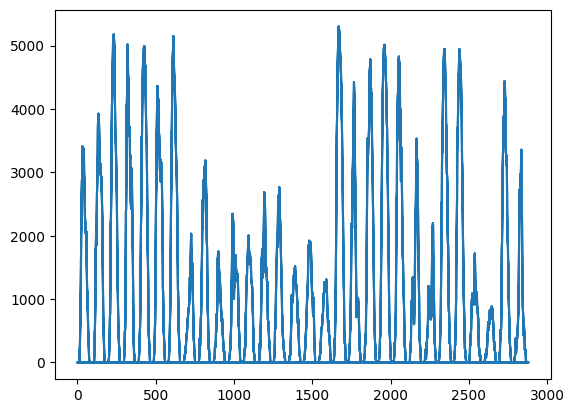

In [24]:
features = ["absolute_humidity_2m:gm3", "air_density_2m:kgm3", "ceiling_height_agl:m", "clear_sky_energy_1h:J", 
            "clear_sky_rad:W", "cloud_base_agl:m", "dew_or_rime:idx", "dew_point_2m:K", "diffuse_rad:W", "diffuse_rad_1h:J", 
            "direct_rad:W", "direct_rad_1h:J", "effective_cloud_cover:p", "is_in_shadow:idx", "msl_pressure:hPa", 
            "precip_5min:mm", "pressure_100m:hPa", "pressure_50m:hPa", "prob_rime:p", "rain_water:kgm2", "relative_humidity_1000hPa:p",
            "sun_azimuth:d", "sun_elevation:d", "super_cooled_liquid_water:kgm2", "t_1000hPa:K", "total_cloud_cover:p", "visibility:m",
            "wind_speed_10m:ms"] #['diffuse_rad:W', 'direct_rad:W', 'is_in_shadow:idx', 'total_cloud_cover:p', 'sun_elevation:d', 'sun_azimuth:d', 't_1000hPa:K']

# Should add features etc, but a bit stranve

# Testing the procedure 
l = learner(file_paths = file_paths, features = features)
l.create_training_data()
l.fit_model()
l.get_performance()
l.predict()

# IDEA: Add a different scaler for all the different features, then transform then into the right scale after the fact
# Remove any needless features, add until you get a good outpu
# Probable reason for the bad score is the scaling defeciencies.